# Mortgage Financial Scenario Models

In [58]:
import pandas as pd
import numpy as np
from datetime import date
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib

In [59]:
%matplotlib inline

In [60]:
matplotlib.style.use('ggplot')

In [10]:
Interest_Rate = 0.02875
Years = 30
Payments_Year = 12
Principal = 142000
Addl_Princ = 50
start_date = (date(2020,1,1))

In [11]:
# Calculate monthly payment 
# But how much is interest and how much is principle
pmt =np.pmt(Interest_Rate/Payments_Year, Years*Payments_Year, Principal)
pmt

-589.1473174480565

In [19]:
# Period to calculate
per = 1

# Calculate the interest
ipmt = np.ipmt(Interest_Rate/Payments_Year, per, Years*Payments_Year, Principal)

# Calculate the principal
ppmt = np.ppmt(Interest_Rate/Payments_Year, per, Years*Payments_Year, Principal)

print(ipmt, ppmt)

-340.20833333333337 -248.9389841147231


In [20]:
per = 240 # Period to calculate 20 years in the future
# Calculate the interest
ipmt = np.ipmt(Interest_Rate/Payments_Year, per, Years*Payments_Year, Principal)

# Calculate the principal
ppmt = np.ppmt(Interest_Rate/Payments_Year, per, Years*Payments_Year, Principal)
print(ipmt, ppmt)

-148.11103246567865 -441.0362849823778


In [23]:
rng = pd.date_range(start_date, periods=Years * Payments_Year, freq='MS')
rng.name = "Payment_Date"


In [27]:
df = pd.DataFrame(index=rng,columns=['Payment', 'Principal', 'Interest', 'Addl_Principal', 'Balance'], dtype='float')
df.reset_index(inplace=True)
df.index += 1
df.index.name = "Period"
df.head()

,Payment_Date,Payment,Principal,Interest,Addl_Principal,Balance
Period,,,,,,
1,2020-01-01,NaN,NaN,NaN,NaN,NaN
2,2020-02-01,NaN,NaN,NaN,NaN,NaN
3,2020-03-01,NaN,NaN,NaN,NaN,NaN
4,2020-04-01,NaN,NaN,NaN,NaN,NaN
5,2020-05-01,NaN,NaN,NaN,NaN,NaN


In [50]:
# NOT CORRECT GOES ABOVE THE FINAL MORTGAGE AMOUTN
# Function to combine them all 
for i in range(2, len(df)+1):
    # Get the previous balance as well as current payments
    prev_balance = df.loc[i-1, 'Balance']
    principal = df.loc[i, 'Principal']
    addl_principal = df.loc[i, "Addl_Principal"]

    # If there is no balance, then do 0 out the principal and interest
    if prev_balance == 0:
        df.loc[i, ['Payment', 'Principal', 'Interest', 'Balance', 'Addl_Principal']] = 0
        continue

    # If this payment does not pay it off, reduce the balance
    if abs(principal + addl_principal) <= prev_balance:
        df.loc[i, 'Balance'] = principal + prev_balance + addl_principal

    # If it does pay it off, zero out the balance and adjust the final payment
    else:
        # Just adjust the principal down
        if prev_balance <= abs(principal):
            principal = -prev_balance
            addl_principal = 0
        else:
            addl_principal = (prev_balance - abs(principal_payment))
        df.loc[i, 'Balance'] = 0
        df.loc[i, 'Principal'] = principal
        df.loc[i, 'Addl_Principal'] = addl_principal
        df.loc[i, "Payment"] = principal +  df.loc[i, "Interest"]

df = df.round(2)
df

,Payment_Date,Payment,Principal,Interest,Addl_Principal,Balance,Cumulative_Principal,Curr_Balance
Period,,,,,,,,
1,2020-01-01,-589.15,-248.94,-340.21,-50,0,-298.94,141701.06
2,2020-02-01,0.00,0.00,0.00,0,0,-598.48,141401.52
3,2020-03-01,0.00,0.00,0.00,0,0,-898.61,141101.39
4,2020-04-01,0.00,0.00,0.00,0,0,-1199.34,140800.66
5,2020-05-01,0.00,0.00,0.00,0,0,-1500.67,140499.33
...,...,...,...,...,...,...,...,...
327,2047-03-01,0.00,0.00,0.00,0,0,-139678.30,2321.70
328,2047-04-01,0.00,0.00,0.00,0,0,-140272.71,1727.29
329,2047-05-01,0.00,0.00,0.00,0,0,-140868.43,1131.57


In [51]:
# Amortization table 
Addl_Principal = 50
df["Payment"] = np.pmt(Interest_Rate/Payments_Year, Years*Payments_Year, Principal)
df["Principal"] = np.ppmt(Interest_Rate/Payments_Year, df.index, Years*Payments_Year, Principal)
df["Interest"] = np.ipmt(Interest_Rate/Payments_Year, df.index, Years*Payments_Year, Principal)
df["Addl_Principal"] = -Addl_Principal
df = df.round(2)
df.head()

,Payment_Date,Payment,Principal,Interest,Addl_Principal,Balance,Cumulative_Principal,Curr_Balance
Period,,,,,,,,
1,2020-01-01,-589.15,-248.94,-340.21,-50,0,-298.94,141701.06
2,2020-02-01,-589.15,-249.54,-339.61,-50,0,-598.48,141401.52
3,2020-03-01,-589.15,-250.13,-339.01,-50,0,-898.61,141101.39
4,2020-04-01,-589.15,-250.73,-338.41,-50,0,-1199.34,140800.66
5,2020-05-01,-589.15,-251.33,-337.81,-50,0,-1500.67,140499.33


In [52]:
# Better way of doing it
df["Balance"] = 0
# not correct
df["Cumulative_Principal"] = (df["Principal"] + df["Addl_Principal"]).cumsum()

# Better way
df["Cumulative_Principal"] = df["Cumulative_Principal"].clip(lower=-Principal)
df["Curr_Balance"] = Principal + df["Cumulative_Principal"]
df.head()

,Payment_Date,Payment,Principal,Interest,Addl_Principal,Balance,Cumulative_Principal,Curr_Balance
Period,,,,,,,,
1,2020-01-01,-589.15,-248.94,-340.21,-50,0,-298.94,141701.06
2,2020-02-01,-589.15,-249.54,-339.61,-50,0,-598.48,141401.52
3,2020-03-01,-589.15,-250.13,-339.01,-50,0,-898.61,141101.39
4,2020-04-01,-589.15,-250.73,-338.41,-50,0,-1199.34,140800.66
5,2020-05-01,-589.15,-251.33,-337.81,-50,0,-1500.67,140499.33


In [53]:
# Last payment 
last_payment = df.query("Curr_Balance <= 0")["Curr_Balance"].idxmax(axis=1, skipna=True)
df.loc[last_payment]

Payment_Date            2047-07-01 00:00:00
Payment                             -589.15
Principal                           -548.34
Interest                             -40.81
Addl_Principal                          -50
Balance                                   0
Cumulative_Principal                -142000
Curr_Balance                              0
Name: 331, dtype: object

In [54]:
# Last payment index
df.loc[last_payment, "Principal"] = -(df.loc[last_payment-1, "Curr_Balance"])
df.loc[last_payment, "Payment"] = df.loc[last_payment, ["Principal", "Interest"]].sum()
df.loc[last_payment, "Addl_Principal"] = 0
df = df.loc[0:last_payment]
df

,Payment_Date,Payment,Principal,Interest,Addl_Principal,Balance,Cumulative_Principal,Curr_Balance
Period,,,,,,,,
1,2020-01-01,-589.15,-248.94,-340.21,-50,0,-298.94,141701.06
2,2020-02-01,-589.15,-249.54,-339.61,-50,0,-598.48,141401.52
3,2020-03-01,-589.15,-250.13,-339.01,-50,0,-898.61,141101.39
4,2020-04-01,-589.15,-250.73,-338.41,-50,0,-1199.34,140800.66
5,2020-05-01,-589.15,-251.33,-337.81,-50,0,-1500.67,140499.33
...,...,...,...,...,...,...,...,...
327,2047-03-01,-589.15,-543.11,-46.04,-50,0,-139678.30,2321.70
328,2047-04-01,-589.15,-544.41,-44.73,-50,0,-140272.71,1727.29
329,2047-05-01,-589.15,-545.72,-43.43,-50,0,-140868.43,1131.57


# Final Funciton All Together

In [55]:
def amortization_table(interest_rate, years, payments_year, principal, addl_principal=0, start_date=date.today()):
    """ Calculate the amortization schedule given the loan details
    
     Args:
        interest_rate: The annual interest rate for this loan
        years: Number of years for the loan
        payments_year: Number of payments in a year
        principal: Amount borrowed
        addl_principal (optional): Additional payments to be made each period. Assume 0 if nothing provided.
                                   must be a value less then 0, the function will convert a positive value to
                                   negative
        start_date (optional): Start date. Will start on first of next month if none provided

    Returns:
        schedule: Amortization schedule as a pandas dataframe
        summary: Pandas dataframe that summarizes the payoff information
    """
    # Ensure the additional payments are negative
    if addl_principal > 0:
        addl_principal = -addl_principal
    
    # Create an index of the payment dates
    rng = pd.date_range(start_date, periods=years * payments_year, freq='MS')
    rng.name = "Payment_Date"
    
    # Build up the Amortization schedule as a DataFrame
    df = pd.DataFrame(index=rng,columns=['Payment', 'Principal', 'Interest', 
                                         'Addl_Principal', 'Curr_Balance'], dtype='float')
    
    # Add index by period (start at 1 not 0)
    df.reset_index(inplace=True)
    df.index += 1
    df.index.name = "Period"
    
    # Calculate the payment, principal and interests amounts using built in Numpy functions
    per_payment = np.pmt(interest_rate/payments_year, years*payments_year, principal)
    df["Payment"] = per_payment
    df["Principal"] = np.ppmt(interest_rate/payments_year, df.index, years*payments_year, principal)
    df["Interest"] = np.ipmt(interest_rate/payments_year, df.index, years*payments_year, principal)
        
    # Round the values
    df = df.round(2) 
    
    # Add in the additional principal payments
    df["Addl_Principal"] = addl_principal
    
    # Store the Cumulative Principal Payments and ensure it never gets larger than the original principal
    df["Cumulative_Principal"] = (df["Principal"] + df["Addl_Principal"]).cumsum()
    df["Cumulative_Principal"] = df["Cumulative_Principal"].clip(lower=-principal)
    
    # Calculate the current balance for each period
    df["Curr_Balance"] = principal + df["Cumulative_Principal"]
    
    # Determine the last payment date
    try:
        last_payment = df.query("Curr_Balance <= 0")["Curr_Balance"].idxmax(axis=1, skipna=True)
    except ValueError:
        last_payment = df.last_valid_index()
    
    last_payment_date = "{:%m-%d-%Y}".format(df.loc[last_payment, "Payment_Date"])
        
    # Truncate the data frame if we have additional principal payments:
    if addl_principal != 0:
                
        # Remove the extra payment periods
        df = df.loc[0:last_payment].copy()
        
        # Calculate the principal for the last row
        df.loc[last_payment, "Principal"] = -(df.loc[last_payment-1, "Curr_Balance"])
        
        # Calculate the total payment for the last row
        df.loc[last_payment, "Payment"] = df.loc[last_payment, ["Principal", "Interest"]].sum()
        
        # Zero out the additional principal
        df.loc[last_payment, "Addl_Principal"] = 0
        
    # Get the payment info into a DataFrame in column order
    payment_info = (df[["Payment", "Principal", "Addl_Principal", "Interest"]]
                    .sum().to_frame().T)
       
    # Format the Date DataFrame
    payment_details = pd.DataFrame.from_dict(dict([('payoff_date', [last_payment_date]),
                                               ('Interest Rate', [interest_rate]),
                                               ('Number of years', [years])
                                              ]))
    # Add a column showing how much we pay each period.
    # Combine addl principal with principal for total payment
    payment_details["Period_Payment"] = round(per_payment, 2) + addl_principal
    
    payment_summary = pd.concat([payment_details, payment_info], axis=1)
    return df, payment_summary

In [69]:
# input interest, year, payment period per year, mortgage and additional principle
schedule1, stats1 = amortization_table(0.02875, 30, 12, 141200, addl_principal=0)
schedule2, stats2 = amortization_table(0.02875, 30, 12, 126200, addl_principal=500)
schedule3, stats3 = amortization_table(0.02875, 30, 12, 126200, addl_principal=750)
schedule4, stats4 = amortization_table(0.02875, 30, 12, 126200, addl_principal=1000)
schedule5, stats5 = amortization_table(0.02875, 30, 12, 126200, addl_principal=1250)
schedule6, stats6 = amortization_table(0.02875, 30, 12, 126200, addl_principal=1500)
schedule7, stats7 = amortization_table(0.02875, 30, 12, 126200, addl_principal=1758)
schedule8, stats8 = amortization_table(0.02875, 30, 12, 126200, addl_principal=2000)
schedule1.head()

,Payment_Date,Payment,Principal,Interest,Addl_Principal,Curr_Balance,Cumulative_Principal
Period,,,,,,,
1,2020-12-01,-585.83,-247.54,-338.29,0,140952.46,-247.54
2,2021-01-01,-585.83,-248.13,-337.70,0,140704.33,-495.67
3,2021-02-01,-585.83,-248.72,-337.10,0,140455.61,-744.39
4,2021-03-01,-585.83,-249.32,-336.51,0,140206.29,-993.71
5,2021-04-01,-585.83,-249.92,-335.91,0,139956.37,-1243.63


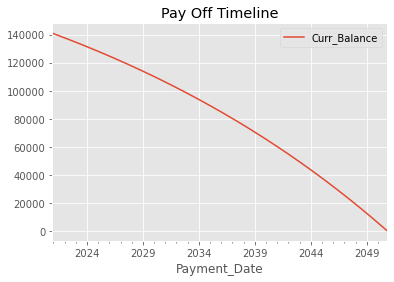

In [61]:
schedule1.plot(x='Payment_Date', y='Curr_Balance', title="Pay Off Timeline");

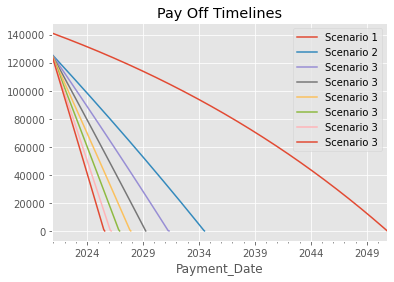

In [70]:

fig, ax = plt.subplots(1, 1)
schedule1.plot(x='Payment_Date', y='Curr_Balance', label="Scenario 1", ax=ax)
schedule2.plot(x='Payment_Date', y='Curr_Balance', label="Scenario 2", ax=ax)
schedule3.plot(x='Payment_Date', y='Curr_Balance', label="Scenario 3", ax=ax)
schedule4.plot(x='Payment_Date', y='Curr_Balance', label="Scenario 3", ax=ax)
schedule5.plot(x='Payment_Date', y='Curr_Balance', label="Scenario 3", ax=ax)
schedule6.plot(x='Payment_Date', y='Curr_Balance', label="Scenario 3", ax=ax)
schedule7.plot(x='Payment_Date', y='Curr_Balance', label="Scenario 3", ax=ax)
schedule8.plot(x='Payment_Date', y='Curr_Balance', label="Scenario 3", ax=ax)
plt.title("Pay Off Timelines");